In [1]:
import syft as sy
import copy
import torch
import torch.nn as nn
from torchvision import datasets ,models,transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/leo6532/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
#Determine if there is a GPU
train_on_gpu = torch.cuda.is_available()
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
PATH_train="./train"
PATH_val="./val"
PATH_test="./test"

In [4]:
TRAIN =Path(PATH_train)
VALID = Path(PATH_val)
TEST=Path(PATH_test)
print(TRAIN)
print(VALID)
print(TEST)

train
val
test


In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# learning rate
LR = 0.001

In [6]:
# convert data to a normalized torch.FloatTensor
train_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((50,50)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [7]:
# choose the training and test datasets
train_data = datasets.ImageFolder(TRAIN, transform=train_transforms)
valid_data = datasets.ImageFolder(VALID,transform=valid_transforms)
test_data = datasets.ImageFolder(TEST, transform=test_transforms)


In [8]:
test_data

Dataset ImageFolder
    Number of datapoints: 1622
    Root location: test
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
print(train_data.class_to_idx)
print(valid_data.class_to_idx)
print(test_data.class_to_idx)

{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}
{'sick': 0, 'unsick': 1}


In [10]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,  num_workers=num_workers,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,  num_workers=num_workers)

In [11]:
images,labels=next(iter(train_loader))
images.shape,labels.shape

(torch.Size([32, 3, 50, 50]), torch.Size([32]))

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
classes = ['sick','unsick']
mean , std = torch.tensor([0.485, 0.456, 0.406]),torch.tensor([0.229, 0.224, 0.225])


def denormalize(image):
  image = transforms.Normalize(-mean/std,1/std)(image) #denormalize
  image = image.permute(1,2,0) #Changing from 3x224x224 to 224x224x3
  image = torch.clamp(image,0,1)
  return image

# helper function to un-normalize and display an image
def imshow(img):
    img = denormalize(img) 
    plt.imshow(img)

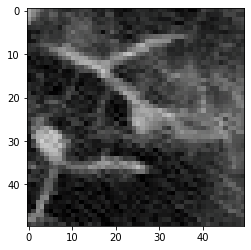

In [13]:
imshow(images[0])

In [14]:
#imshow(images[2])

/home/leo6532/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


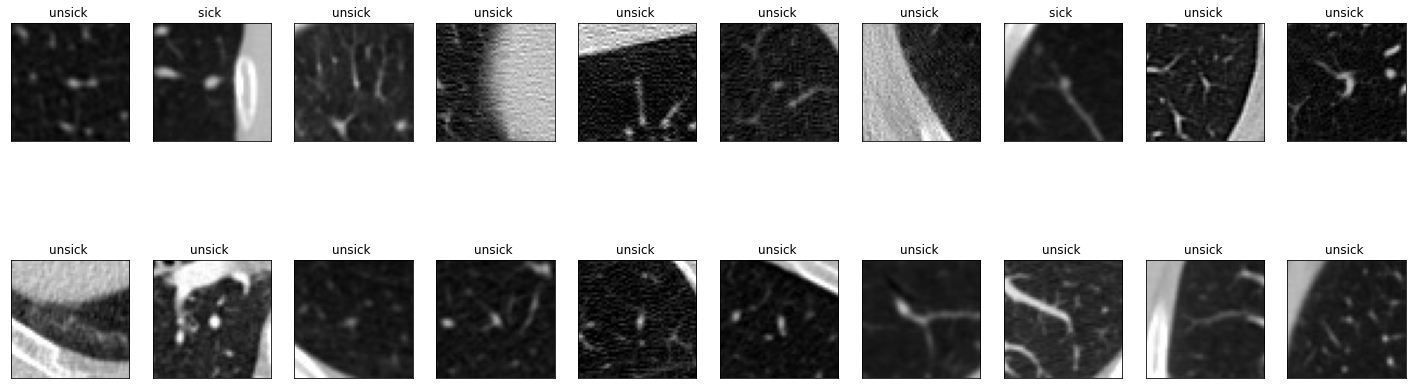

In [15]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
 # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
#display 20 images
for idx in np.arange(20):
     ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
     imshow(images[idx])
     ax.set_title("{} ".format( classes[labels[idx]]))

In [16]:
# Create CNN Model
class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0) #output_shape=(16,220,220) 48
        #(224-5+1)/1 #(weigh-kernel+1)/stride 無條件進位
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) #output_shape=(16,110,110) #(220/2) 16 24 24
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) #output_shape=(32,106,106) 20 20
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=1) #output_shape=(32,53,53) 10 10
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=1, stride=1, padding=0) #output_shape=(16,51,51) 10 10
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=1) #output_shape=(16,25,25) 5 5
        self.cnn4 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=1, stride=1, padding=0) #output_shape=(8,23,23) 5 5
        self.relu4 = nn.ReLU()
        self.maxpool4 = nn.MaxPool2d(kernel_size=2) #output_shape=(8,11,11) 8 5 5
        # Fully connected 1 ,#input_shape=(8*12*12)
        self.fc1 = nn.Linear(8 * 11 * 11, 512) 
        #self.relu5 = nn.ReLU() # activation
        self.fc2 = nn.Linear(512, 2) 
        #self.output = nn.Softmax(dim=1)
        
    
    def forward(self, x):
        out = self.cnn1(x) # Convolution 1
        out = self.relu1(out)
        out = self.maxpool1(out)# Max pool 1
        out = self.cnn2(out) # Convolution 2
        out = self.relu2(out) 
        out = self.maxpool2(out) # Max pool 2
        out = self.cnn3(out) # Convolution 3
        out = self.relu3(out)
        out = self.maxpool3(out) # Max pool 3
        out = self.cnn4(out) # Convolution 4
        out = self.relu4(out)
        out = self.maxpool4(out) # Max pool 4
        out = out.view(out.size(0), -1) # last CNN faltten con. Linear NN
        out = self.fc1(out) # Linear function (readout)
        out = self.fc2(out)
        #out = self.output(out)

        return out

In [17]:
model = CNN_Model()
from torchsummary import summary
summary(model.cuda(), (3, 50, 50))
#summary(model, (3, 50, 50),device = "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 48, 48]             448
              ReLU-2           [-1, 16, 48, 48]               0
         MaxPool2d-3           [-1, 16, 24, 24]               0
            Conv2d-4           [-1, 32, 22, 22]           4,640
              ReLU-5           [-1, 32, 22, 22]               0
         MaxPool2d-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 16, 22, 22]             528
              ReLU-8           [-1, 16, 22, 22]               0
         MaxPool2d-9           [-1, 16, 22, 22]               0
           Conv2d-10            [-1, 8, 22, 22]             136
             ReLU-11            [-1, 8, 22, 22]               0
        MaxPool2d-12            [-1, 8, 11, 11]               0
           Linear-13                  [-1, 512]         496,128
           Linear-14                   

In [18]:
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm

In [19]:
import torch.optim as optim    
optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
criterion = nn.CrossEntropyLoss() 

running epoch: 1



	Training Loss: 0.438884 	Validation Loss: 0.420760
Validation loss decreased (inf --> 0.420760).  Saving model ...
[0.4388841459786522]
[0.4207604069524116]


/home/leo6532/.local/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


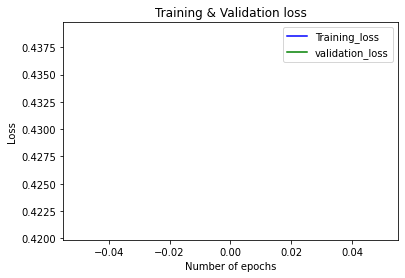

In [20]:
if train_on_gpu:
    model.cuda()
# number of epochs to train the model
n_epochs = 1 #170


valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]

train_loss_i = [] 
valid_loss_i = []
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    #train_losses.append(train_loss/len(train_loader.dataset))
    #valid_losses.append(valid_loss.item()/len(valid_loader.dataset)
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        train_loss, valid_loss))
    
    #作圖接收矩陣
    train_loss_i.append(train_loss)
    valid_loss_i.append(valid_loss)

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_CNN.pth')
        torch.save(model, "o_model.pth")
        valid_loss_min = valid_loss
#作圖區
print(train_loss_i) 
print(valid_loss_i)

plt.plot(range(n_epochs), train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#TEST MODEL

In [21]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}'.format(test_loss))

    print('Test Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [22]:
use_cuda = torch.cuda.is_available()
model.cuda()
test(test_loader, model, criterion, use_cuda)

Test Loss: 0.420649
Test Accuracy: 82% (1341/1622)


In [23]:
model_1 = torch.load('model_CNN.pth')

In [24]:
model_1

OrderedDict([('cnn1.weight',
              tensor([[[[ 0.1031,  0.0921,  0.0612],
                        [-0.1779, -0.1225, -0.0058],
                        [-0.0409,  0.0145,  0.0978]],
              
                       [[-0.0388,  0.0945, -0.0917],
                        [ 0.1248,  0.1881,  0.1531],
                        [-0.1756,  0.0766,  0.0445]],
              
                       [[-0.1345, -0.1122,  0.0903],
                        [ 0.1674, -0.1234,  0.1740],
                        [ 0.1272, -0.0362, -0.1153]]],
              
              
                      [[[ 0.1083,  0.0327, -0.1732],
                        [ 0.0086, -0.0496, -0.0525],
                        [-0.1923,  0.0166, -0.1830]],
              
                       [[-0.1600,  0.0798,  0.1833],
                        [-0.1431,  0.0636,  0.0570],
                        [-0.1487,  0.1233, -0.1325]],
              
                       [[-0.0258, -0.0189, -0.1052],
                        [-0

# 虛擬環境執行 model

In [25]:
hook = sy.TorchHook(torch)
bob = sy.VirtualWorker(hook, id="bob")
alice = sy.VirtualWorker(hook, id="alice")
secure_worker = sy.VirtualWorker(hook, id="secure_worker")
compute_nodes = [bob, alice]


In [26]:
model = CNN_Model().cuda()

In [27]:
bobs_data = data.copy().send(bob)
bobs_target = target.copy().send(bob)
#alices_data = data.copy().send(alice)
#alices_target = target.copy().send(alice)

In [28]:
bobs_model = model.copy().send(bob)
alices_model = model.copy().send(alice)

In [29]:
#bobs_opt = torch.optim.Adam(bobs_model.parameters(), lr=LR)   
#alices_opt = optim.SGD(params=alices_model.parameters(),lr=0.1) 
#optimizer = torch.optim.Adam(model.parameters(), lr=LR) 
#criterion = nn.CrossEntropyLoss() 

In [30]:
bob._objects

{76925063127: tensor([[[[-1.7069, -1.6555, -1.6213,  ..., -1.6727, -1.5014, -1.5185],
           [-1.6555, -1.7925, -1.7240,  ..., -1.6555, -1.6042, -1.6384],
           [-1.5528, -1.7069, -1.6555,  ..., -1.6042, -1.5699, -1.6042],
           ...,
           [-0.3027, -1.0733, -1.2959,  ..., -1.6042, -1.5699, -1.5699],
           [-0.1657, -0.7993, -1.2274,  ..., -1.5185, -1.5528, -1.5870],
           [ 0.0912, -0.5253, -0.9705,  ..., -1.5357, -1.5528, -1.5870]],
 
          [[-1.6155, -1.5630, -1.5280,  ..., -1.5805, -1.4055, -1.4230],
           [-1.5630, -1.7031, -1.6331,  ..., -1.5630, -1.5105, -1.5455],
           [-1.4580, -1.6155, -1.5630,  ..., -1.5105, -1.4755, -1.5105],
           ...,
           [-0.1800, -0.9678, -1.1954,  ..., -1.5105, -1.4755, -1.4755],
           [-0.0399, -0.6877, -1.1253,  ..., -1.4230, -1.4580, -1.4930],
           [ 0.2227, -0.4076, -0.8627,  ..., -1.4405, -1.4580, -1.4930]],
 
          [[-1.3861, -1.3339, -1.2990,  ..., -1.3513, -1.1770, -1.1944],


# 一定要把model get回來才能使用

In [31]:
bobs_data.get()

tensor([[[[-1.7069, -1.6555, -1.6213,  ..., -1.6727, -1.5014, -1.5185],
          [-1.6555, -1.7925, -1.7240,  ..., -1.6555, -1.6042, -1.6384],
          [-1.5528, -1.7069, -1.6555,  ..., -1.6042, -1.5699, -1.6042],
          ...,
          [-0.3027, -1.0733, -1.2959,  ..., -1.6042, -1.5699, -1.5699],
          [-0.1657, -0.7993, -1.2274,  ..., -1.5185, -1.5528, -1.5870],
          [ 0.0912, -0.5253, -0.9705,  ..., -1.5357, -1.5528, -1.5870]],

         [[-1.6155, -1.5630, -1.5280,  ..., -1.5805, -1.4055, -1.4230],
          [-1.5630, -1.7031, -1.6331,  ..., -1.5630, -1.5105, -1.5455],
          [-1.4580, -1.6155, -1.5630,  ..., -1.5105, -1.4755, -1.5105],
          ...,
          [-0.1800, -0.9678, -1.1954,  ..., -1.5105, -1.4755, -1.4755],
          [-0.0399, -0.6877, -1.1253,  ..., -1.4230, -1.4580, -1.4930],
          [ 0.2227, -0.4076, -0.8627,  ..., -1.4405, -1.4580, -1.4930]],

         [[-1.3861, -1.3339, -1.2990,  ..., -1.3513, -1.1770, -1.1944],
          [-1.3339, -1.4733, -

In [32]:
bobs_target.get()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')

### get一次就好 第2次會error
bobs_model.get()

In [33]:
s_model.get()

In [34]:
bob._objects

{47800172882: Parameter containing:
 tensor([[[[ 1.4411e-01,  4.8044e-02,  1.5667e-01],
           [-6.9742e-02, -1.0600e-01, -9.3168e-02],
           [ 1.5696e-01,  1.1007e-01, -1.5391e-01]],
 
          [[ 1.3840e-01,  8.2646e-02,  1.3837e-01],
           [-5.0527e-02,  1.6959e-01,  8.1059e-02],
           [-1.8254e-01,  1.4518e-01,  6.8445e-02]],
 
          [[ 1.6874e-02, -1.6126e-01,  5.0331e-02],
           [ 1.2071e-01,  1.1834e-02,  8.3263e-02],
           [-1.2532e-01,  1.4734e-02, -1.5167e-01]]],
 
 
         [[[ 1.4148e-01, -1.8918e-01,  1.6273e-01],
           [-1.6796e-01, -6.8526e-03,  1.9235e-01],
           [-6.1703e-02,  1.5789e-01, -2.3505e-02]],
 
          [[-5.2750e-02,  1.5104e-01,  5.5994e-02],
           [ 1.0762e-01,  1.3270e-01,  1.8635e-01],
           [ 3.5706e-02,  5.5491e-02,  1.8048e-01]],
 
          [[-1.4690e-01, -1.6249e-02,  5.3030e-02],
           [ 1.7516e-01,  1.8396e-01, -2.7121e-02],
           [-1.5519e-01,  1.4440e-01, -1.7861e-01]]],
 
 
    

# Node training 

In [35]:
# number of epochs to train the model
bobs_train_loss_i = []
bobs_valid_loss_i = []


n_epochs = 10 #170


bobs_valid_loss_min = np.Inf # track change in validation loss

#train_losses,valid_losses=[],[]
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    bobs_train_loss = 0.0
    bobs_valid_loss = 0.0
    print('running epoch: {}'.format(epoch))
    ###################
    # train the model #
    ###################
    bobs_model.train()
    for bobs_data, bobs_target in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            bobs_data, bobs_target = bobs_data.cuda(),  bobs_target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = bobs_model(bobs_data)
        # calculate the batch loss
        loss = criterion(output,bobs_target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        bobs_train_loss += loss.item()*bobs_data.size(0)
    for bobs_data, bobs_target in tqdm(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            bobs_data, bobs_target = bobs_data.cuda(), bobs_target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        
        with torch.no_grad():
            output = bobs_model(bobs_data)
        # calculate the batch loss
        loss = criterion(output,bobs_target)
        # update average validation loss 
        bobs_valid_loss += loss.item()* bobs_data.size(0)   
        
        
    bobs_train_loss = bobs_train_loss/len(train_loader.dataset)    
    bobs_valid_loss = bobs_valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('\tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
         bobs_train_loss,  bobs_valid_loss))    
    #作圖接收矩陣
    bobs_train_loss_i.append(bobs_train_loss)
    bobs_valid_loss_i.append(bobs_valid_loss)
    if bobs_valid_loss <= bobs_valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        bobs_valid_loss_min,
        bobs_valid_loss))
        bobs_valid_loss_min = bobs_valid_loss
#作圖區
print(bobs_train_loss_i) 
print(bobs_valid_loss_i)    
    
#圖區    
plt.plot(range(n_epochs), bobs_train_loss_i,'b-', label='Training_loss')
plt.plot(range(n_epochs), bobs_valid_loss_i,'g-', label='validation_loss')
plt.title('Training & Validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()    

running epoch: 1


RuntimeError: weight should have at least three dimensions

In [ ]:
test(test_loader, bobs_model, criterion, use_cuda)

# Model's  weight Calculation

In [ ]:
params=bobs_model.state_dict() 
for k,v in params.items():
    print(k)
    
    
print(params['cnn1.weight'])
print(params['cnn1.bias'])

In [ ]:
print(model.state_dict())

# Print model's all weight

In [ ]:
for name, para in bobs_model.named_parameters():
    print('{}: {}'.format(name, para.shape))
    #print(para.shape)
for name, para in alices_model.named_parameters():
    print('{}: {}'.format(name, para.shape))
    #print(para.shape)    


In [ ]:
list([mode1, mode2, model3, model4])

# 1. 初始化model,資料分割並傳送給其他人 (資料科學家，你想要train一個模型，可是你沒有資料)
# 2. 傳送model到有資料的人，讓有資料的人去訓練 model，要可以設定epoch摩es
# 3. 資料科學家aggregate模型參數
# 4. 資料科學家更新有資料的人的model






# aggregate
# 初始化設定 第一個model agg_model = model_array(0)
# 




for param in bobs_model.parameters():
    print((param.data + param.data)/2)

In [ ]:
import torch
from torchvision import models

m = models.resnet18()
print(m)
print('-'*60)
for l in list(m.named_parameters()):
    print(l[0], ':', l[1].detach().numpy().shape)